### Tittle option
# Option 1: Snowpark Python: Run your Data Science where your data lives: A hands-on guide

# Option 2: Snowpark Python: How to migrate your DS projects.

Python for Snowpark has just been released, and now we have the ability to run our models closer of were our data lives, using Snowflake procesing power to run our model prediction. 

In this example we're going to take a fairly known dataset **[California Housing Prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices)**, upload the data  into Snowflake using **Snowpark for Python**, we will do a quick data exploration, crossvalidation and fine-tunning, to then deploy our model into Snowflake to get our predictions using Snowflake's data warehouse. 



## 1. Load necesary Snowpark packages and connect to Snowflake

We will begin by importing necesary libraries, the session class will give us everything we need to connect to Snowflake, using the same parameters from the connect function in the Snowflake Connector for Python. To create a session we will build a Python dictionary containing the names and values of the parameters, see example below. 

For this example, we placed those parameters in a different file called "config".

In [ ]:
import os

connection_parameters = {
    "account": os.environ["snowflake_account"],
    "user": os.environ["snowflake_user"],
    "password": os.environ["snowflake_password"],
    "role": os.environ["snowflake_user_role"],
    "warehouse": os.environ["snowflake_warehouse"],
    "database": os.environ["snowflake_database"],
    "schema": os.environ["snowflake_schema"]
  }

We will also import standart machine learning libraries like pandas, numpy and Matplotlib, and several snowpark libraries like functions that provides utility and SQL functions to generate column expressions to pass to DataFrame transformation methods, date types, and UDF to build our predictions in Snowflake. 



In [2]:
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#Snowflake connection info is saved in config.py
from config import snowflake_conn_prop

# lets import the udf function
from snowflake.snowpark.functions import udf

Print Snowpark version

In [2]:
from snowflake.snowpark import version
print(version.VERSION)

(0, 6, 0, None)


We'll load our data using pd.read() and pull a sample.

In [3]:
#Read the housing data

#data=pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv')
#this one will work once we release and make the repo public
## TODO : Include public URL
#You can download the data from our public repo
#data=pd.read_csv('https://raw.githubusercontent.com/Hakkoda1/Snowpark_migrate/main/housing.csv')
data=pd.read_csv('/Users/sbrenes/Snowpark/customer-churn-prediction/housing.csv')

data.columns= ['LONGITUDE',
 'LATITUDE',
 'HOUSING_MEDIAN_AGE',
 'TOTAL_ROOMS',
 'TOTAL_BEDROOMS',
 'POPULATION',
 'HOUSEHOLDS',
 'MEDIAN_INCOME',
 'MEDIAN_HOUSE_VALUE',
 'OCEAN_PROXIMITY']

In [4]:
data.head()

,LONGITUDE,LATITUDE,HOUSING_MEDIAN_AGE,TOTAL_ROOMS,TOTAL_BEDROOMS,POPULATION,HOUSEHOLDS,MEDIAN_INCOME,MEDIAN_HOUSE_VALUE,OCEAN_PROXIMITY
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Now let's create a connection.

We will pass the dictionary containing the name and values of the parameters from config.py to the session.builder.configs method to return a object with the parameters to call th create method and stablish connection.

In [5]:
session = Session.builder.configs(snowflake_conn_prop).create()

To create our environment in snowflake you can load different variables with the rolename, database, schema, warehouse name and create them running SQL in Snowflake with the session.sql command. You can update these to adapt your snowflake environment, just make sure the role has create priviledges for the database.
Snowpark operations are lazy, which means that to trigger queries you need to call and action function, like the collect function.


In [6]:
rolename = "SYSADMIN"
dbname = "DEMO"
schemaname = "TEST"
warehouse = "HOUSING_LAB_S_WH"

session.sql(f"USE ROLE {rolename}").collect()

[Row(status='Statement executed successfully.')]

In [7]:
#  Create a database, schema, warehouse)
session.sql(f"CREATE DATABASE IF NOT EXISTS {dbname}").collect()
session.sql(f"CREATE SCHEMA IF NOT EXISTS {dbname}.{schemaname}").collect()
session.sql(f"CREATE WAREHOUSE  IF NOT EXISTS {warehouse} \
                WAREHOUSE_SIZE = 'SMALL' \
                AUTO_SUSPEND = 300 \
                AUTO_RESUME = TRUE \
                MIN_CLUSTER_COUNT = 1 \
                MAX_CLUSTER_COUNT = 3 \
                SCALING_POLICY = 'STANDARD' ").collect()

[Row(status='LAB_S_WH already exists, statement succeeded.')]

In [8]:
session.sql(f"USE WAREHOUSE {warehouse}").collect()
session.sql(f"USE SCHEMA {dbname}.{schemaname}").collect()

[Row(status='Statement executed successfully.')]

In [9]:
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

[Row(CURRENT_WAREHOUSE()='LAB_S_WH', CURRENT_DATABASE()='DEMO', CURRENT_SCHEMA()='TEST')]


Now, to explain the whole process, we will load our csv into Snowflake and use it for our analysis, in your case the data might already be in Snowflake, which is great. 

The following variable names contain our file name, in this case, housing.csv, the name of the stage we will create, and the raw table name.

The session.fle.put command will load the file in the stage, 

Note: for this example it's important to have our file in the same folder as the notebook.



In [10]:
filename = "housing.csv"
stagename = "rawdata"
rawtable = "housing"

In [11]:
# Create Snowflake stage
session.sql(f"create or replace stage {stagename} DIRECTORY = (ENABLE = TRUE);").collect()

# Put the file in the stage
session.file.put(filename,stagename)

[PutResult(source='housing.csv', target='housing.csv.gz', source_size=1423529, target_size=396000, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

Let's create our schema by using a SructType containing names of the columns and data types of such columns, then we'll call the schema property to return an object configured to read files containing the specified fields and with the options property we define the format fields like compressions, field delimiter, type and skipping the header, with the csv option we define the location of our file in the stage and then the copy into creates our table.

In [13]:


schema_for_data_file = StructType([
    StructField("longitude",IntegerType()),
    StructField("latitude",IntegerType()),
    StructField("housing_median_age",IntegerType()),
    StructField("total_rooms",IntegerType()),
    StructField("total_bedrooms",IntegerType()),
    StructField("population",IntegerType()),
    StructField("households",IntegerType()),
    StructField("median_income",IntegerType()),
    StructField("median_house_value",IntegerType()),
    StructField("ocean_proximity",StringType())])


In [14]:
csv_reader=session.read.schema(schema_for_data_file)

In [15]:
format_options={"compression": "gzip",  "type" : "csv", "field_delimiter" : ",","skip_header": 1}
csv_reader=csv_reader.options(format_options)

In [16]:
df = csv_reader.csv("@rawdata/housing.csv.gz")

In [18]:
# In case you already have a table there

drop_result = session.sql(f"drop table if exists {rawtable}").collect() 
drop_result

[Row(status='HOUSING successfully dropped.')]

In [19]:

df_table=df.copy_into_table("housing",format_type_options=format_options ,force=True)

In [20]:
%%time

housing_snowflake = session.table('housing')

pd.pandas.set_option('display.max_columns', None)

data = housing_snowflake.toPandas()
data.head()

CPU times: user 526 ms, sys: 51.8 ms, total: 578 ms
Wall time: 3.03 s


,LONGITUDE,LATITUDE,HOUSING_MEDIAN_AGE,TOTAL_ROOMS,TOTAL_BEDROOMS,POPULATION,HOUSEHOLDS,MEDIAN_INCOME,MEDIAN_HOUSE_VALUE,OCEAN_PROXIMITY
0,-122,38,41,880,129.0,322,126,8,452600,NEAR BAY
1,-122,38,21,7099,1106.0,2401,1138,8,358500,NEAR BAY
2,-122,38,52,1467,190.0,496,177,7,352100,NEAR BAY
3,-122,38,52,1274,235.0,558,219,6,341300,NEAR BAY
4,-122,38,52,1627,280.0,565,259,4,342200,NEAR BAY


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LONGITUDE           20640 non-null  float64
 1   LATITUDE            20640 non-null  float64
 2   HOUSING_MEDIAN_AGE  20640 non-null  float64
 3   TOTAL_ROOMS         20640 non-null  float64
 4   TOTAL_BEDROOMS      20433 non-null  float64
 5   POPULATION          20640 non-null  float64
 6   HOUSEHOLDS          20640 non-null  float64
 7   MEDIAN_INCOME       20640 non-null  float64
 8   MEDIAN_HOUSE_VALUE  20640 non-null  float64
 9   OCEAN_PROXIMITY     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Perform Exploratory Data Analysis (EDA)

Now that we have our data in Snowflake we can decide if we want to work with Snowpark python or with our preferred Python native libraries like numpy and pandas.

We will perform a histogram on numeric variables to see how our data is represented.

At first glance we can see that this attributes have very different ranges, we will work on this later and do feature scaling. 

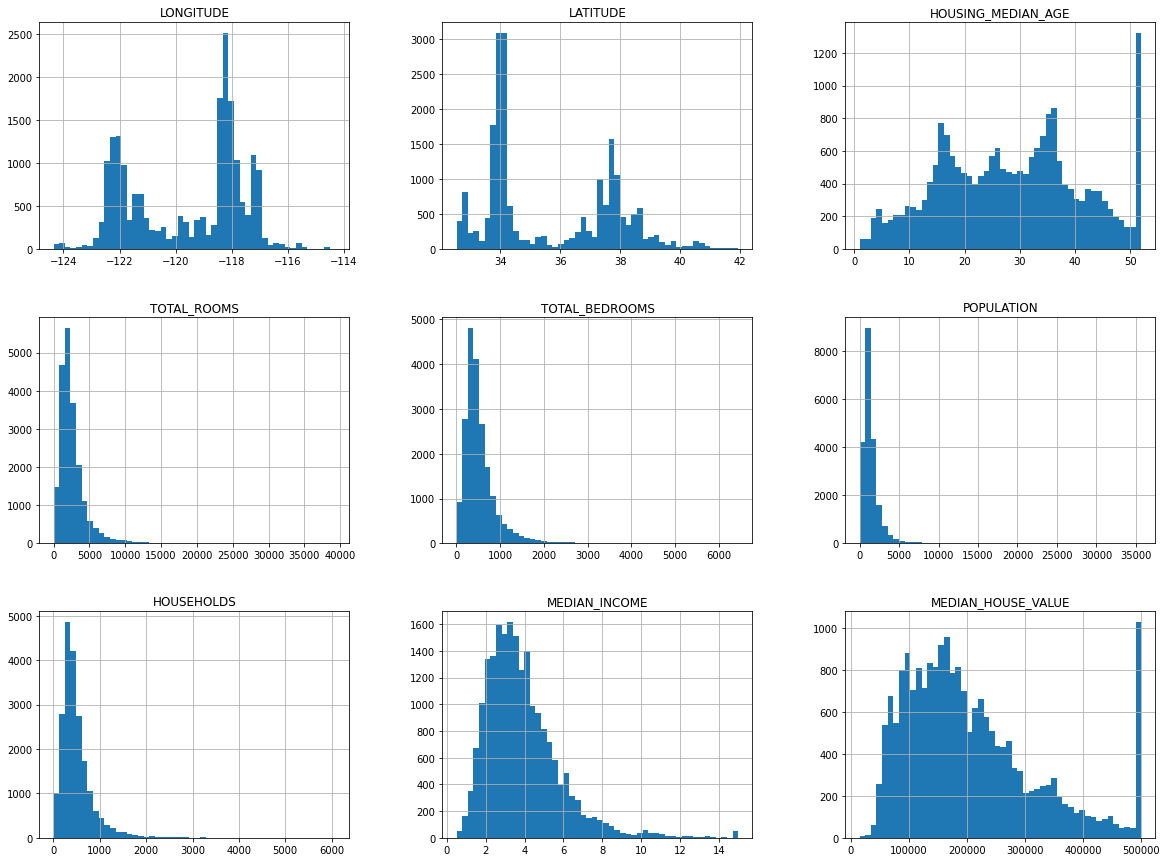

In [6]:
data.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
cat_vars = [var for var in data.columns if ((data[var].dtype == 'O') or (data[var].dtype=="bool"))]
print(cat_vars)

num_vars = [var for var in data.columns if var not in cat_vars]
print(num_vars)


['OCEAN_PROXIMITY']
['LONGITUDE', 'LATITUDE', 'HOUSING_MEDIAN_AGE', 'TOTAL_ROOMS', 'TOTAL_BEDROOMS', 'POPULATION', 'HOUSEHOLDS', 'MEDIAN_INCOME', 'MEDIAN_HOUSE_VALUE']



Median income is an important predictor for median housing prices, so we will create a new attribute with pd.cut() called INCOME_CAT, that will define 5 categories (labeled from 1 to 5) based on Median_INCOME cuts. 

In [11]:
data["INCOME_CAT"] = pd.cut(data["MEDIAN_INCOME"],
 bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
 labels=[1, 2, 3, 4, 5])

Then some clean up is required, we will run code detect null values in our dataset.

In [12]:
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

mean_val=data[vars_with_na].isnull().sum().sort_values(ascending=False)
sum_val=data[vars_with_na].isnull().mean().sort_values(ascending=False)


Variables TOTAL_BEDROOMS and INCOME_CAT have 207 and 12 null values respectively.

In [13]:
pd.concat([mean_val.rename('sum'),sum_val.rename('mean')],axis=1)

,sum,mean
TOTAL_BEDROOMS,207,0.010029


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   LONGITUDE           20640 non-null  float64 
 1   LATITUDE            20640 non-null  float64 
 2   HOUSING_MEDIAN_AGE  20640 non-null  float64 
 3   TOTAL_ROOMS         20640 non-null  float64 
 4   TOTAL_BEDROOMS      20433 non-null  float64 
 5   POPULATION          20640 non-null  float64 
 6   HOUSEHOLDS          20640 non-null  float64 
 7   MEDIAN_INCOME       20640 non-null  float64 
 8   MEDIAN_HOUSE_VALUE  20640 non-null  float64 
 9   OCEAN_PROXIMITY     20640 non-null  object  
 10  INCOME_CAT          20640 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB


In this case, for example purpuses, we're going to drop the na's but calculating the mean is also an option if the dataset is small and you need each and every row.

In [15]:
data=data.dropna(subset=['TOTAL_BEDROOMS','INCOME_CAT'])

In [16]:

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   LONGITUDE           20433 non-null  float64 
 1   LATITUDE            20433 non-null  float64 
 2   HOUSING_MEDIAN_AGE  20433 non-null  float64 
 3   TOTAL_ROOMS         20433 non-null  float64 
 4   TOTAL_BEDROOMS      20433 non-null  float64 
 5   POPULATION          20433 non-null  float64 
 6   HOUSEHOLDS          20433 non-null  float64 
 7   MEDIAN_INCOME       20433 non-null  float64 
 8   MEDIAN_HOUSE_VALUE  20433 non-null  float64 
 9   OCEAN_PROXIMITY     20433 non-null  object  
 10  INCOME_CAT          20433 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.7+ MB


Since we have out set cleaned o null values we will perform a stratified split of our data based on INCOME_CAT, we can be sure that our test set has almost the same proportion of income categories than the full dataset. Note: More on why this is important at reference 2 pag. 57 and 58. 

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["INCOME_CAT"]):
 strat_train_set = data.iloc[train_index]
 strat_test_set = data.iloc[test_index]

We drop the INCOME_CAT to get the dataset to the initial state and split our features.


In [18]:
# TODO : Check when to perform the drop.
#data=data.drop('INCOME_CAT',axis=1)
data = strat_train_set.drop(['MEDIAN_HOUSE_VALUE', 'INCOME_CAT'], axis=1)
data_labels = strat_train_set["MEDIAN_HOUSE_VALUE"].copy()

And perform transformation for numerical values and categorical values. In this section we create a transformation pipeline using standardScaler(), as mentioned before when we built our histogram, the attributes of this dataset have very different scales and is important to get them all in the same range, we will also perform a OneHotEncoder to transfor categorical variables into numbers. 

In [19]:
data_cat = data[["OCEAN_PROXIMITY"]]
data_num = data.drop("OCEAN_PROXIMITY", axis=1)

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
 ('std_scaler', StandardScaler()),
 ])
data_num_tr = num_pipeline.fit_transform(data_num)



num_attribs = list(data_num)
cat_attribs = ["OCEAN_PROXIMITY"]
full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])
data_prepared = full_pipeline.fit_transform(data)

## Train and evaluate the model using Cross validation

Having our data clean and perform an extensive exploration are important steps in any Data Science modelling process, so far we have done it at a high level, but I encourage you to do a deep dive and understand your data as much as possible. 

We're getting into the fun part, testing different machine learning algoritms and see how it perform in our data. 

We will start with simple Linear regression, using crossvalidation to split the training set into 10 subsets, to evaluate the model 10 times, with a different fold everry time. Let's see how well it does it. 


In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

#best practice of repeated k-fold cross-validation with 3 repeats and 10 folds. Check this fact
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)


linear_reg = LinearRegression()
linear_reg.fit(data_prepared, data_labels)
linear_scores = cross_val_score(linear_reg, data_prepared, data_labels, scoring="neg_mean_squared_error", cv=cv)
linear_rmse_scores = np.sqrt(-linear_scores)

#create function for printing scores
def print_scores(scores):
    print (f' Mean:  {scores.mean()} \n Standart deviation: {scores.std()} \n\n Scores: {scores}')
    
print_scores(linear_rmse_scores)

 Mean:  69074.45289191636 
 Standart deviation: 2065.35711255224 

 Scores: [69409.72482934 66440.04782011 68861.36427355 68868.26566486
 67620.10872067 69273.74693297 65536.86929921 70819.6908918
 75020.15018402 68379.52619984 69624.33466882 68546.61716369
 66803.50042429 66924.2785971  69224.75624337 71983.99453759
 71740.73397233 66848.79899075 70168.18885823 69080.4591481
 70617.89757939 69566.79127908 70844.6205866  69191.20134518
 68296.47856266 70473.16595759 65382.99365239 69051.89337138
 71373.95246315 66259.43453944]


Not a great score, having a $69661 of prediction error is not very satisfying, let's try other algorithms.

In [161]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(data_prepared, data_labels)
tree_scores = cross_val_score(tree_reg, data_prepared, data_labels, scoring="neg_mean_squared_error", cv=cv)
tree_rmse_scores = np.sqrt(-tree_scores)
print_scores(tree_rmse_scores)

 Mean:  80791.99528233192 
 Standart deviation: 1935.031337582773 

 Scores: [82998.01394915 76860.39917914 78923.57872257 81028.57953614
 82560.59609811 82531.79074024 81903.00970476 80246.80217811
 81868.55137893 77235.40889582 82715.25385025 80200.85233855
 82315.53336981 81900.13402185 81482.34119943 79568.99986616
 81390.66393511 81156.65354724 83034.09190093 75100.41591242
 79308.22830443 82764.07940545 80522.90749226 80111.04166708
 82488.40907513 83256.42351328 80712.54377736 80235.88024413
 78938.51861603 80400.1560501 ]


Decision Trees performs even worse with a median score of $80792

In [ ]:
%pip install xgboost

In [166]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor()
knn_reg.fit(data_prepared, data_labels)
knn_scores = cross_val_score(knn_reg, data_prepared, data_labels, scoring="neg_mean_squared_error", cv=cv)
knn_rmse_scores = np.sqrt(-knn_scores)
print_scores(knn_rmse_scores)



 Mean:  63163.316117758026 
 Standart deviation: 1793.6749099874107 

 Scores: [66538.71634304 61364.17115479 63775.86973605 63611.66262149
 62211.9050135  61999.33750688 62770.50258435 63199.9335667
 66899.03361428 60159.60255247 65549.91195697 61007.32447644
 64467.43746634 63580.00049866 61213.74374844 62584.07513247
 61161.01330897 62567.96194796 66412.83000481 64256.4875851
 60813.30013116 64505.17290534 60681.08546139 63073.89525194
 61834.41024635 65273.40807938 63807.2863684  64647.76185937
 62733.02868879 62198.61372091]


With KNN we get a sligtly better result of 63163 for the prediction error, but let's try Random Forest and see if we can do better.

In [22]:
from sklearn.ensemble import RandomForestRegressor
forest_regression = RandomForestRegressor()
forest_regression.fit(data_prepared, data_labels)
forest_scores = cross_val_score(forest_regression, data_prepared, data_labels, scoring="neg_mean_squared_error", cv=cv)
forest_rmse_scores = np.sqrt(-forest_scores)
print_scores(forest_rmse_scores)



 Mean:  48748.79694865395 
 Standart deviation: 1769.2771277121342 

 Scores: [47711.85129333 47240.84784409 50120.63156622 47973.13670894
 47505.43722516 50241.7207659  44952.38542366 51307.22451471
 51943.53081142 48354.08776296 49363.13804767 47782.06768937
 46582.5973054  47540.71399958 48703.77114533 51561.4697794
 48796.31857497 46853.55596376 49622.33870737 49480.74280856
 51771.81772591 48665.86635961 51138.85302217 48955.69289003
 46652.81639946 49848.94681105 46668.48499194 50604.35608805
 47222.2366078  47297.26962579]


That's better, I think you get the idea at this point, it's important to check different algorithms and evaluate which one can give you best results, but let's dive a little more and fine tune some parameters to improve our results, fortunately Scikit-learn offers a handy library that allows to test different parameter combinations. 

### Fine tune model with RandomizedSearch

Instead of trying manually each parameter combination, with Randomized you can try a large list of parameters, to test on every iteration a number of random combinations selecting a random value each round for each hyperparameter.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

parameters = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7, 0.8, 0.9,1.0],
           'subsample': np.arange(0.1, 1.0, 0.1),
           'colsample_bytree': np.arange(0.1, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.1, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

xgb_reg = XGBRegressor()

random_search=RandomizedSearchCV(estimator=xgb_reg,
                         param_distributions=parameters,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         cv=5,
                         random_state=42,
                         verbose=1)
random_search.fit(data_prepared, data_labels)

In [ ]:
random_search.best_params_

In [ ]:
random_search.best_estimator_

In [ ]:
cvres = random_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f' {np.sqrt(-mean_score)}, \n {params}')

In [ ]:
from scipy.stats import expon, reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
random_svr_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=1, random_state=42)
random_svr_search.fit(data_prepared, data_labels)

In [59]:
random_svr_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

In [ ]:
svres= random_svr_search.best_params_
for mean_score, params in zip(svres["mean_test_score"], svres["params"]):
    print(f' {np.sqrt(-mean_score)}, \n {params}')

In [ ]:
random_svr_search.best_params_


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
random_search = RandomizedSearchCV(forest_regression, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
random_search.fit(data_prepared, data_labels)

If you want, you can evaluate your model in python prior to deploying to Snowflakle.

In [53]:
from sklearn.metrics import mean_squared_error

final_model = random_search.best_estimator_
X_test = strat_test_set.drop("MEDIAN_HOUSE_VALUE", axis=1)
y_test = strat_test_set["MEDIAN_HOUSE_VALUE"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) 

In [54]:
final_rmse

57614.76374960302

# Deploy the model in Snowflake

Once our model is trained and tuned, and we are satisifed with the accuracy, let's proceed to deploy it in Snowflake using python UDFs.

First we create a stage to store the artifacts.

In [42]:
print(session.sql('create stage if not exists MODELSTAGE').collect())

[Row(status='MODELSTAGE already exists, statement succeeded.')]


Then we specify the Anaconda packages to install using **session.add_packages**. The **@udf** decorator will package the function as Snowflake Python UDF and save the model into Snowflake's internal stage.

The full_pipeline.transform will apply transformations done in the training set. In this case we will use the Random Forest model that we just trained.

The session.table will load a HOUSING sample of 10 rows in snow_df, then we will call the UDF we created "predict_housing" with the statement call_udf from the functions library, the array_construct will an array based on our feature and then we will save our table as "housing_detection" and call the prediction column "PREDICTED_HOUSE_VALUE".

In [56]:
%%time

features = list(data.columns)
final_model = random_search.best_estimator_
session.add_packages("scikit-learn==1.0.2", "pandas", "numpy")

@udf(name='predict_housing',is_permanent = True, stage_location = '@MODELSTAGE', replace=True)
def predict_housing(args: list) -> float:
    row = full_pipeline.transform(pd.DataFrame([args], columns=features))
    return final_model.predict(row)
   # return forest_reg.predict(row)
   # TODO : Remove commmented line

CPU times: user 5.65 s, sys: 1.31 s, total: 6.96 s
Wall time: 1min 16s


In [77]:
snow_df = session.table('HOUSING').sample(n = 10)

In [81]:
%%time
snow_df.select(snow_df.LONGITUDE,snow_df.MEDIAN_HOUSE_VALUE, \
              F.call_udf("predict_housing", F.array_construct(*features)).alias('PREDICTED_HOUSE_VALUE')) \
        .write.mode('overwrite').saveAsTable('housing_detection')

CPU times: user 8.25 ms, sys: 2.45 ms, total: 10.7 ms
Wall time: 9.25 s


And finally we pulled the "HOUSING_DETECTION" from snowflake and display our results as a Pandas dataframe.

In [82]:
session.table('HOUSING_DETECTION').toPandas()

,LONGITUDE,MEDIAN_HOUSE_VALUE,PREDICTED_HOUSE_VALUE
0,-120,60600,64973.00
1,-119,63300,63584.00
2,-118,366200,365407.01
3,-118,262100,283993.03
4,-118,214600,169367.00
5,-122,179800,184869.00
6,-118,222800,171059.00
7,-118,137500,139847.00
8,-118,181000,246292.09
9,-122,246100,276129.04


And this is the view we get in a Housing_Detection table with our predictions located in our Snowflake database.

![Snowflake predictions](./pictures/Snowflake_predictions.png)

# Summary

In this article/tutorial, you discovered how to take an already available data science model and migrate it to Snowflake using Snowpark for python.

Specifically:
- How to connect to Snowflake
- Loading data using Snowpark functions like copy_into
- Connect to your data in Snowflake
- Perform data science predictive modeling in our data with EDA, Cross-validation and fine tunnning 
- Deploy the model in Snowflake with UDF python functions.

I hope you enjoyed the tutorial as much as we did creating it, a closing thought, ff you no longer need to use a session for executing queries and  want to cancel any queries that are currently running calling the close method of the Session object is a good practice.

In [ ]:
session.close()

In [ ]:
#TODO Change to official documentation

# More information and references 


1. Snowpark Developer Guide for Python https://docs.snowflake.com/en/LIMITEDACCESS/snowpark-python.html#label-snowpark-python-dataframe-action-method

2. Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow by Aurélien Géron (O’Reilly).Copyright 2019 Aurélien Géron, 978-1-492-03264-9.





